### Python implementation of Stain Normalization of H&E stained images following the algorithm of Macenko et al.

### This implelemtation is copied from the github repo of https://github.com/schaugf/HEnorm_python

In [3]:
import numpy as np
import cv2
import os

import numpy as np
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:



def normalizeStaining(img, saveFile=None, Io=240, alpha=1, beta=0.15):
    ''' Normalize staining appearence of H&E stained images
    
    Example use:
        see test.py
        
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
        
    Output:
        Inorm: normalized image
        H: hematoxylin image
        E: eosin image
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    maxCRef = np.array([1.9705, 1.0308])
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    img = img.reshape((-1,3))

    # calculate optical density
    #OD = -np.log((img.astype(np.float)+1)/Io)
    OD = -np.log((img.astype(np.float64)+1)/Io)
    
    # remove transparent pixels
    ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    #eigvecs *= -1
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # unmix hematoxylin and eosin
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    if saveFile is not None:
        Image.fromarray(Inorm).save(saveFile+'.png')
        Image.fromarray(H).save(saveFile+'_H.png')
        Image.fromarray(E).save(saveFile+'_E.png')

    return Inorm, H, E

In [14]:


def stain_normalization(img_name):
    
    img_dir = 'data_320X320_xywh_val_sample'
    #img_file1 = 'b1bdee8e5e3372174619_334_198.jpeg'
    img = np.array(Image.open(os.path.join(img_dir, img_file1)))

    Inorm, H, E = normalizeStaining(img = img,
                      saveFile = None,
                      Io = 240,
                      alpha = 1.0,
                      beta = 0.15)

    ncols = 2
    nrows = 2 

    imgs = [img, Inorm, H, E]
    titles = ['original', 'Normalized', 'H', 'E']

    fig, ax_array = plt.subplots(nrows, ncols, figsize=(12,12))
    axes = ax_array.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i])
        ax.set_title(titles[i])
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0.5, w_pad=0.01)
    plt.show()
    
    print(type(Inorm), type(H))
    

### Choose an image and look at the 3 images from the stain normalization output

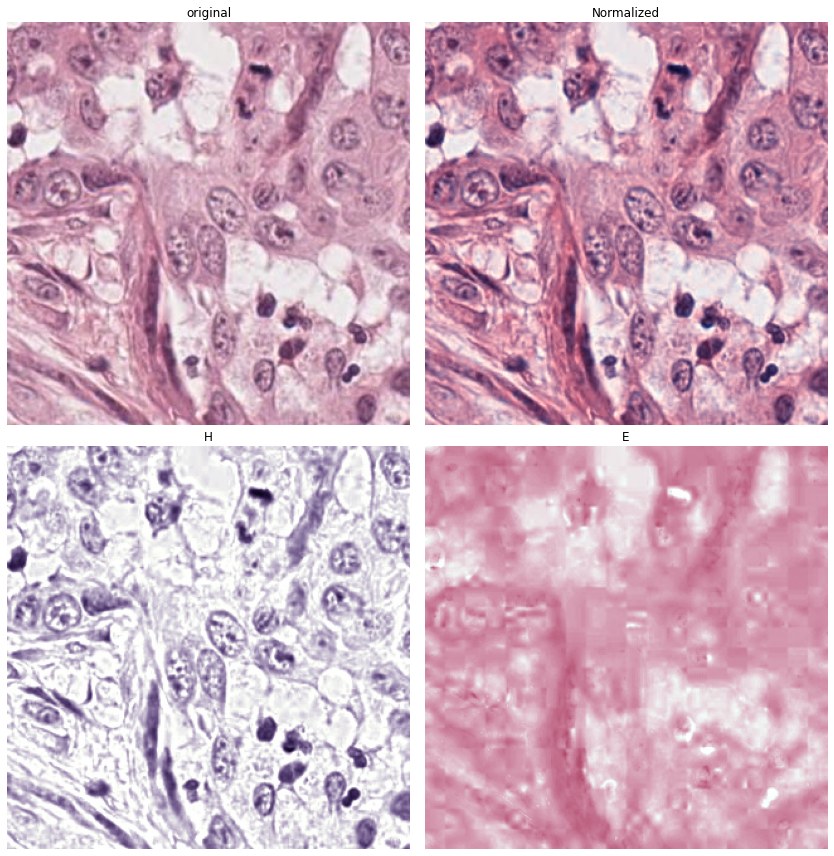

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [15]:
img_file1 = 'b1bdee8e5e3372174619_334_198.jpeg'
stain_normalization(img_file1)

### Choose another image and look at the 3 images from the stain normalization output

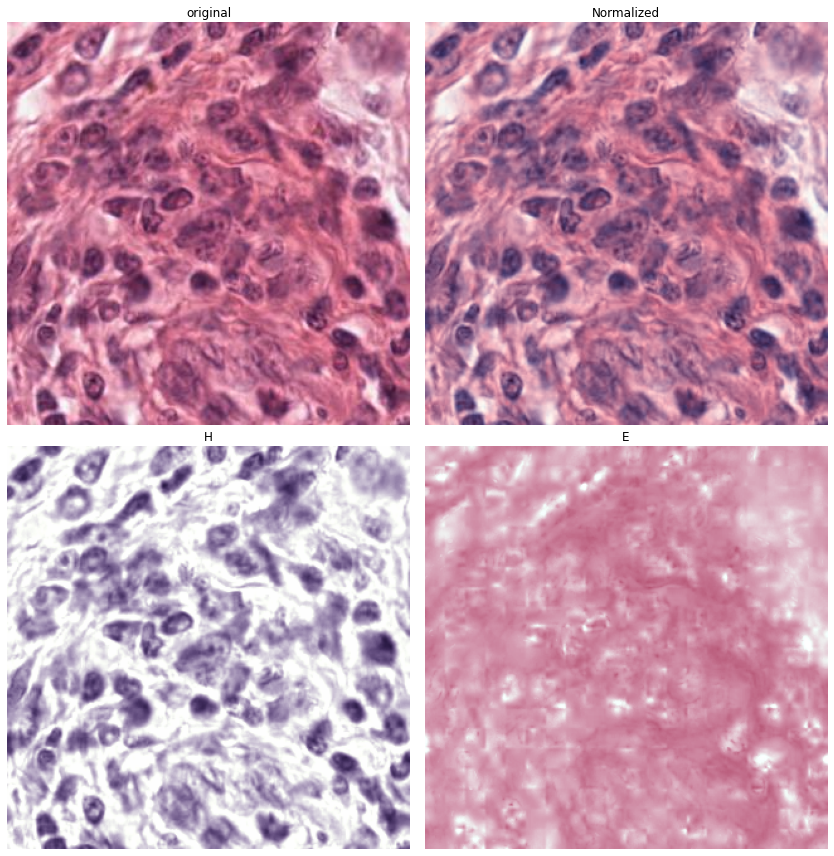

In [8]:
img_file1 = '022857018aa597374b6c_167_207.jpeg'
stain_normalization(img_file1)